# Check cell true trace

_Before cells' extracellular potentials are summed into lfp_

This is only available from ground truth experiment/simulations.

# Setup 

Setup Jupyter notebook's kernel based on python env setup with `requirements_silico.txt` (see comments in file for setup)

In [10]:
%load_ext autoreload
%autoreload 2

import logging
import logging.config
import yaml 
import os
import pprint as pp
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd; 
import json
from datetime import datetime

# Move to project
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting"
os.chdir(PROJ_PATH)

from src.nodes.utils import get_config, write_metadata
from src.nodes.io.silico.loading import load_campaign_params
from src.nodes.dataeng.silico import probe_wiring


# SET CONFIG PARAM
EXPERIMENT = "supp/silico_reyes"    # specifies the experiment 
SIMULATION_DATE = "2023_01_13" # specifies the run (date)
CHANNEL_ID = np.arange(64,80).tolist()                           # plot traces from channels nearest to filtered neuron group
CELL_GID = 3754013                                               # most active near-probe pyramidal cell

# SET CONFIG
data_conf, param_conf = get_config(EXPERIMENT, SIMULATION_DATE).values()


# SET DATA PATHS
# set input data paths
CELL_TRACE_PATH = data_conf["dataeng"]["campaign"]["output"]["unit_trace_path"]
SPIKE_PATH = data_conf["dataeng"]["campaign"]["output"]["spike_file_path"]


# set output figure paths
FIG_PATH = data_conf["figures"]["silico"]["cell_true_traces"]


# SET PIPELINE PARAMETERS
CAMPAIGN_PARAMS = load_campaign_params(data_conf)
LFP_SAMPLING_FREQ = CAMPAIGN_PARAMS["lfp_sampling_freq"]         # Hz
SPIKE_SAMPLING_FREQ = CAMPAIGN_PARAMS["spike_sampling_freq"]     # Hz

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2023-03-20 16:59:24,640 - root - utils.py - get_config - INFO - Reading experiment config.
2023-03-20 16:59:24,678 - root - utils.py - get_config - INFO - Reading experiment config. - done


**Trace data description**

In [2]:
most_active_pyr_trace = pd.read_pickle(
    os.path.join(
        CELL_TRACE_PATH,
        f"cell_{CELL_GID}_trace.pkl",
    )
)
print("trace timepoints (count): ", most_active_pyr_trace.shape[0])
print("trace duration (secs):", most_active_pyr_trace.shape[0] / LFP_SAMPLING_FREQ)
print("channels (count): ", most_active_pyr_trace.shape[1])
most_active_pyr_trace.head()
print("ten example files:", os.listdir(CELL_TRACE_PATH)[:10], "\n")

trace timepoints (count):  799900
trace duration (secs): 39.995
channels (count):  128
ten example files: ['cell_3754013_trace.pkl'] 



**Spike data description**

In [3]:
# get chosen cell's spikes
spikes = pd.read_pickle(SPIKE_PATH)
cell_spikes = spikes[spikes == CELL_GID]

# describe cell spike data
print("selected cell:", CELL_GID)
print("cell's spike largest timestamp (msecs): ", max(cell_spikes.index))
print("cell's spike dataset:")
cell_spikes.head()

selected cell: 3754013
cell's spike largest timestamp (msecs):  39880.27500005207
cell's spike dataset:


t
549.825     3754013
551.025     3754013
604.100     3754013
605.200     3754013
1253.000    3754013
Name: gid, dtype: int64

**Spike and trace synchrony**

In [4]:
# check that spike and trace ranges match
print(
    "min:",
    min(most_active_pyr_trace[0].index),
    "max:",
    max(most_active_pyr_trace[0].index),
)
print("min:", cell_spikes.index[0], "max:", max(cell_spikes.index))

min: 0.0 max: 39999.950000057856
min: 549.825 max: 39880.27500005207


```diff
- Results: We validated that, as expected, a cell's spike timestamps are synchronized with its extracellular action potentials. Its action potential peak amplitudes gradually 1) go down as we move away from channel 71 (the channel nearest to its true location) and 2) gradually transitions from negative to positive as we move from the leftward channels of channel 71 to its rightward channels.
````

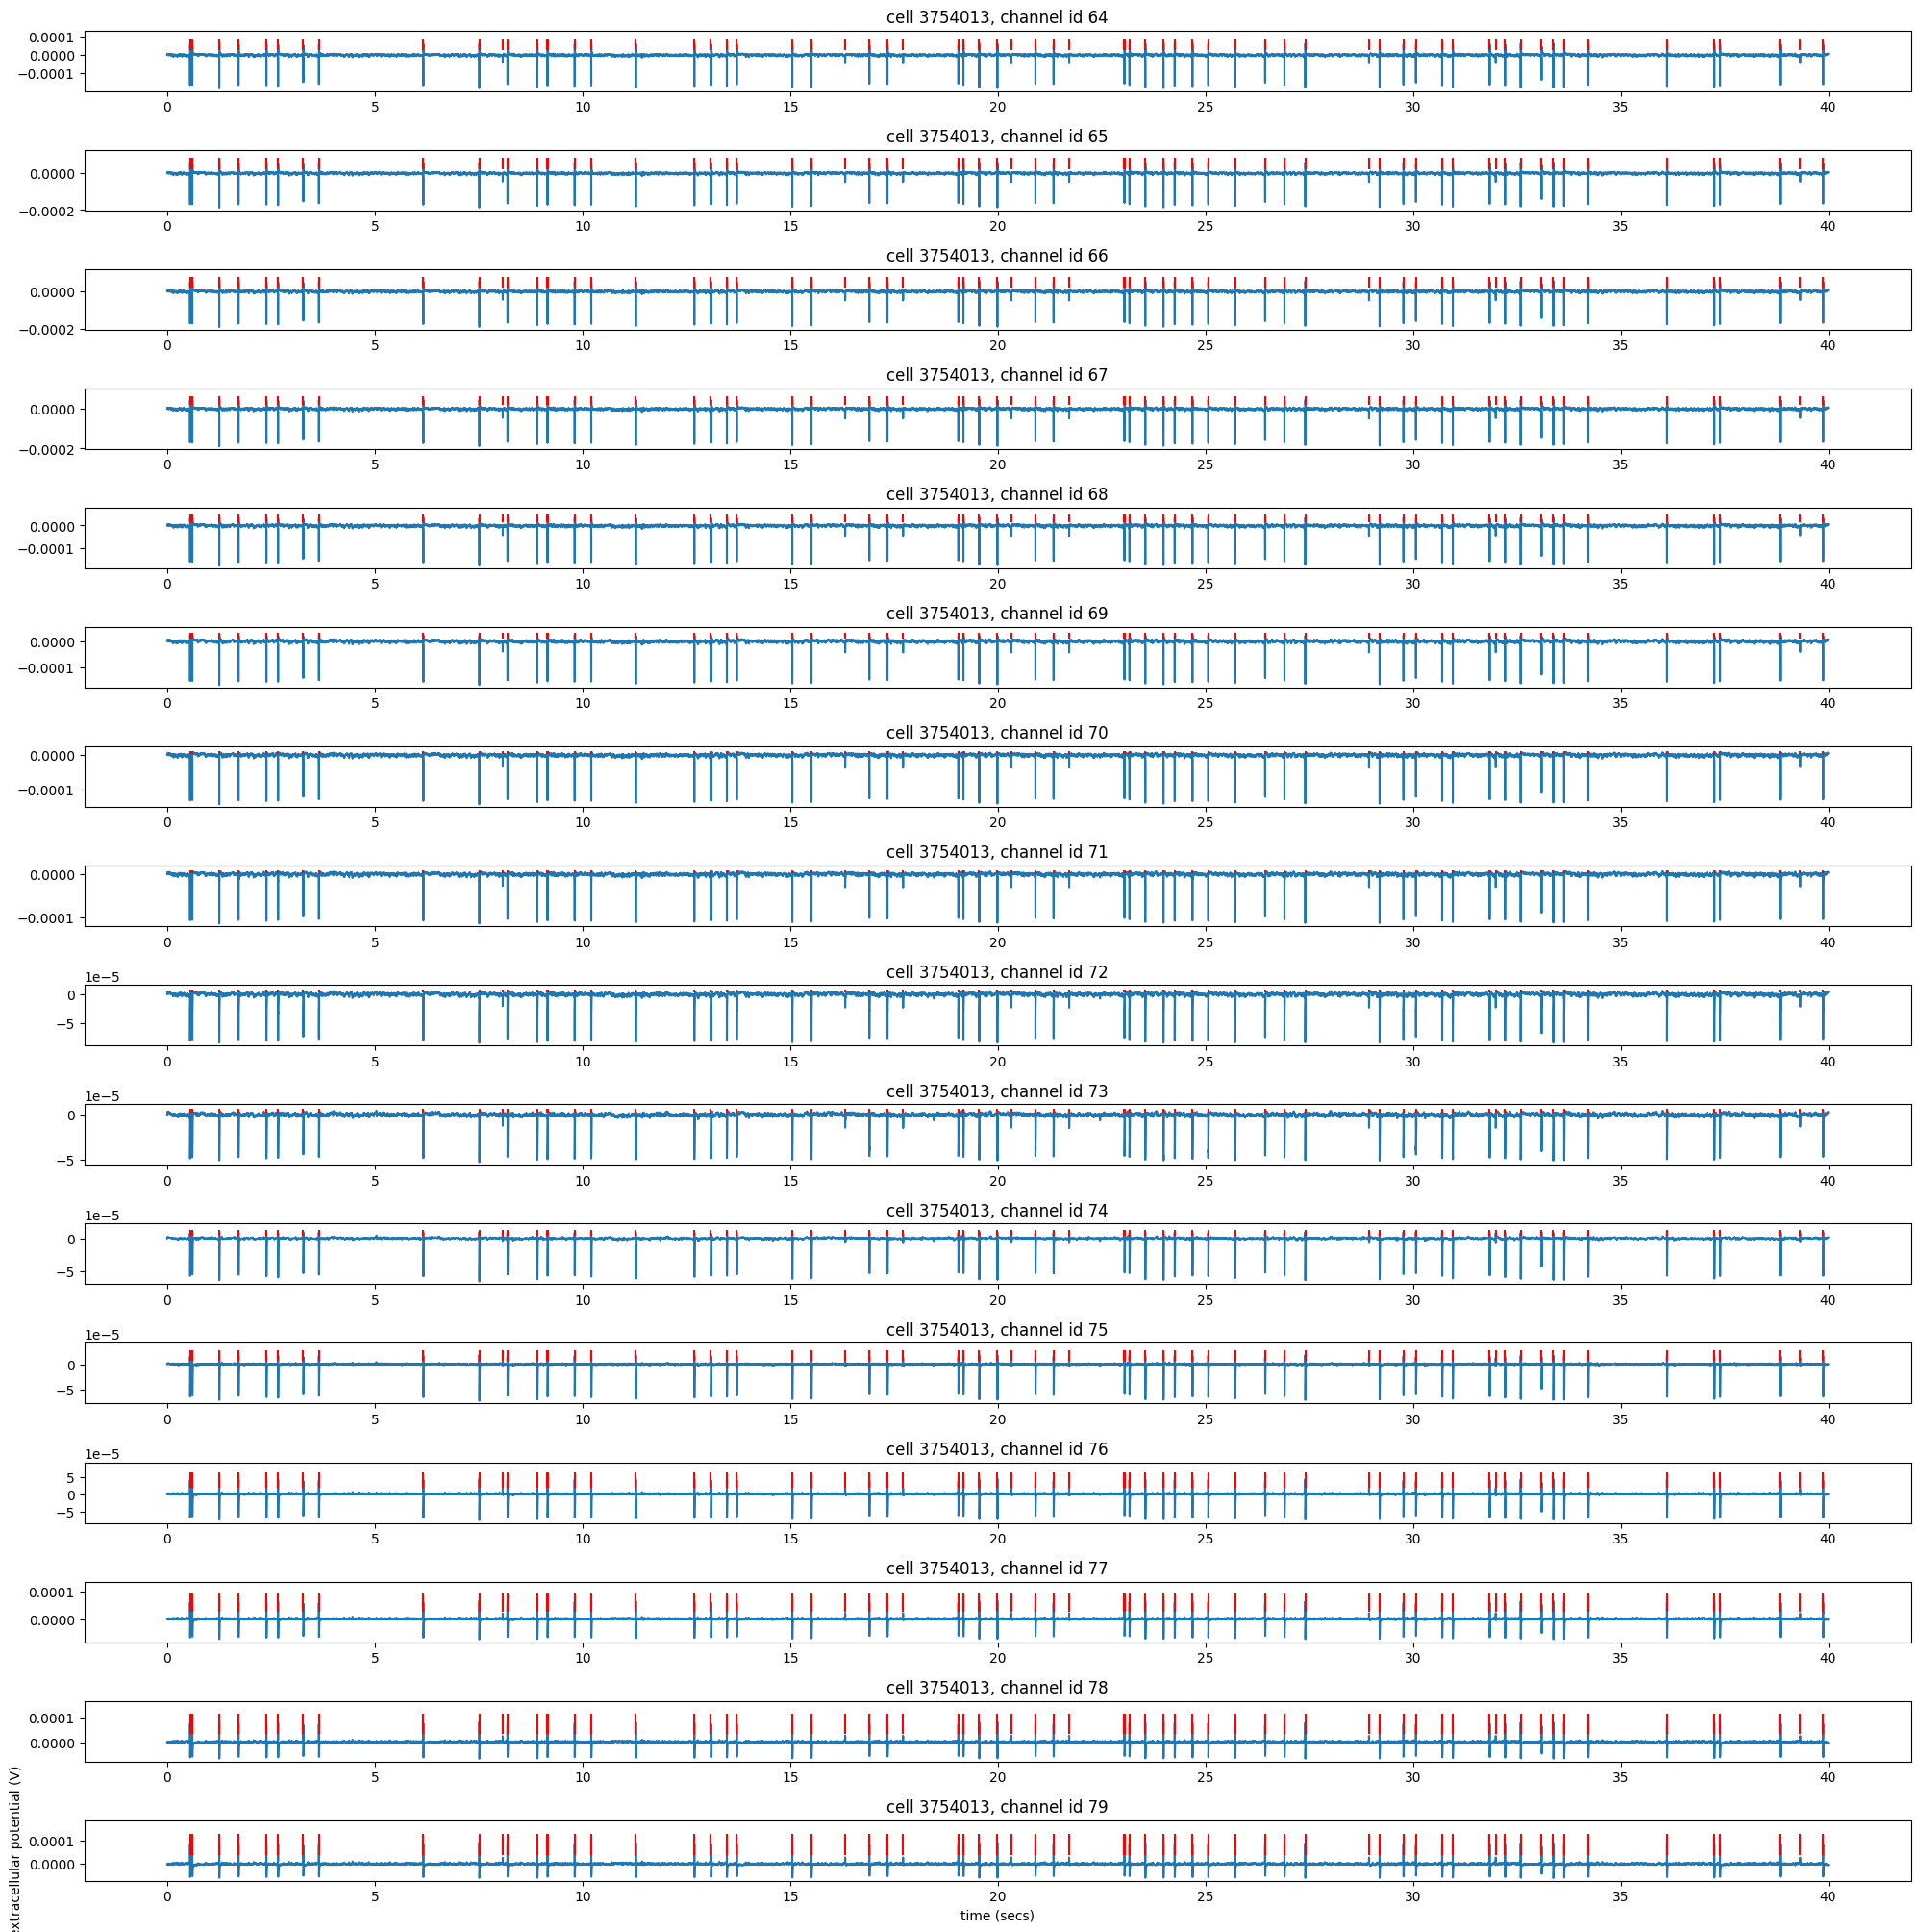

In [5]:
# initialize plot
n_channels = len(CHANNEL_ID)
fig, axes = plt.subplots(n_channels, 1, figsize=(20, 20))

# plot cell trace by channel
for c_i in range(n_channels):

    # convert trace indices from ms to seconds
    t_secs = most_active_pyr_trace[c_i].index / 1000

    # plot
    axes[c_i].plot(t_secs, most_active_pyr_trace[c_i])

    # convert spike timestamps from ms to seconds
    spike_t_secs = cell_spikes.index / 1000

    # mark spikes
    MIN_MAX_AMPLITUDE = [
        most_active_pyr_trace[c_i].min(),
        most_active_pyr_trace[c_i].max(),
    ]
    axes[c_i].eventplot(
        spike_t_secs,
        linelengths=MIN_MAX_AMPLITUDE[1],
        lineoffsets=MIN_MAX_AMPLITUDE[1] * 0.9,
        colors="r",
    )
    axes[c_i].set_title(f"cell {CELL_GID}, channel id {CHANNEL_ID[c_i]}")
plt.tight_layout()
plt.xlabel("time (secs)")
plt.ylabel("extracellular potential (V)")

## Check cell's spikes on nearest channel

In [6]:
def get_unit_waveform(trace, spike_time, ms_before=3, ms_after=3):
    waveform = []
    for spike in spike_time:
        this_waveform = trace[int(spike - ms_before) : int(spike + ms_after)]
        waveform.append(this_waveform)
    return waveform

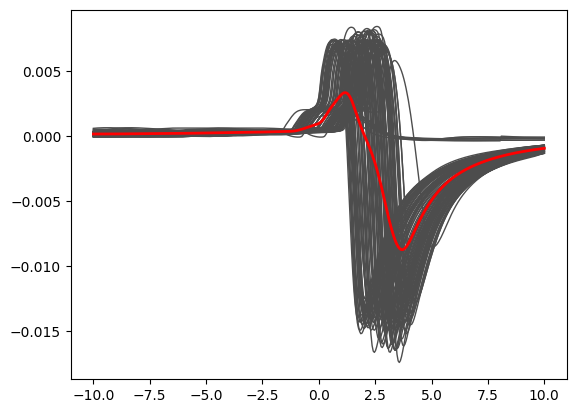

In [7]:
wvs = get_unit_waveform(
    most_active_pyr_trace.loc[:, 75], cell_spikes.index, ms_before=10, ms_after=10
)
min_len = min([len(ix) for ix in wvs])
wv2 = []
for wv in wvs:
    wv2.append(wv.values[:min_len])

wavef = np.array(wv2)
plt.plot(np.linspace(-10, 10, min_len), wavef.T, color=[0.3, 0.3, 0.3], linewidth=1)
plt.plot(
    np.linspace(-10, 10, min_len), np.mean(wavef.T, axis=1), color="r", linewidth=2
)

## Locate cell

In [12]:
# get chosen cell's coordinate$
simulation = load_campaign_params(data_conf)

cell_coord = simulation["circuit"].cells.get(CELL_GID, properties=["x", "y", "z"])
print("cell coordinates:\n", cell_coord)

# wire the recording with its probe and get the probe's contact coordinates
recording = probe_wiring.load(data_conf)
probe = recording.get_probe()
probe_coord = probe.contact_positions.astype(float)
print("contact x-y coordinates:\n", probe_coord[:, :1])

cell coordinates:
 x    3820.476353
y     -1143.5028
z   -2538.452514
Name: 3754013, dtype: object
contact x-y coordinates:
 [[3333.81242423]
 [3378.99014513]
 [3424.16786603]
 [3469.34558693]
 [3514.52330784]
 [3559.70102874]
 [3604.87874964]
 [3650.05647054]
 [3695.23419145]
 [3740.41191235]
 [3785.58963325]
 [3830.76735415]
 [3875.94507506]
 [3921.12279596]
 [3966.30051686]
 [4011.47823777]
 [3382.43500685]
 [3427.61272776]
 [3472.79044866]
 [3517.96816956]
 [3563.14589046]
 [3608.32361137]
 [3653.50133227]
 [3698.67905317]
 [3743.85677407]
 [3789.03449498]
 [3834.21221588]
 [3879.38993678]
 [3924.56765769]
 [3969.74537859]
 [4014.92309949]
 [4060.10082039]
 [3431.05758948]
 [3476.23531038]
 [3521.41303129]
 [3566.59075219]
 [3611.76847309]
 [3656.94619399]
 [3702.1239149 ]
 [3747.3016358 ]
 [3792.4793567 ]
 [3837.6570776 ]
 [3882.83479851]
 [3928.01251941]
 [3973.19024031]
 [4018.36796122]
 [4063.54568212]
 [4108.72340302]
 [3479.68017211]
 [3524.85789301]
 [3570.03561391]
 [3615.2

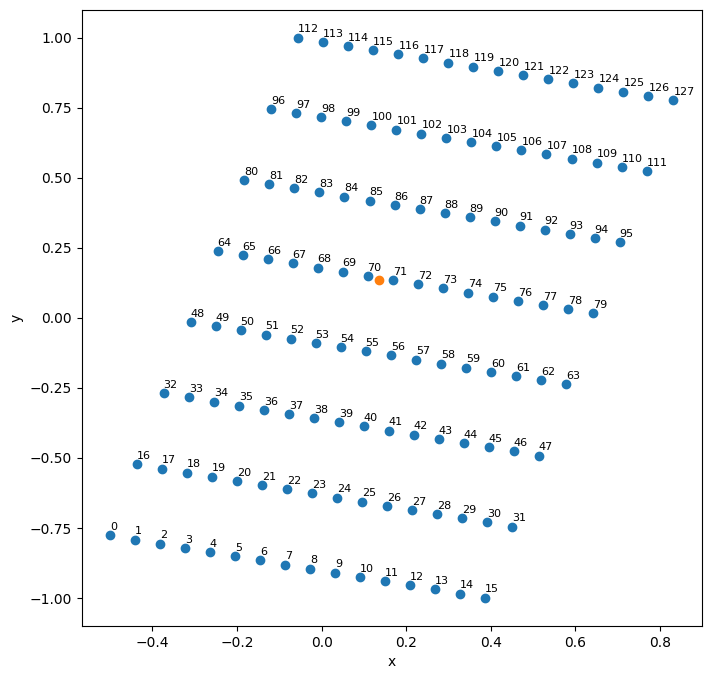

In [13]:
# scale coordinates linearly between -1 and 1 for plot (0 being the cell coordinates)
norm_contact_coord = np.subtract(probe_coord[:, :2], cell_coord.values[:2])
ncc = norm_contact_coord
ncc_max = norm_contact_coord.max().max()
ncc_min = norm_contact_coord.min().min()
scaled_contact_coord = (ncc - ncc_min) / (ncc_max - ncc_min) * 2 - 1

# normalize cell
norm_cell_coord = np.array([0, 0])
scaled_cell_coords = (norm_cell_coord - ncc_min) / (ncc_max - ncc_min) * 2 - 1

# plot
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(scaled_contact_coord[:, 0], scaled_contact_coord[:, 1], "o")
ax.plot(scaled_cell_coords[0], scaled_cell_coords[1], "o")
ax.set_xlabel("x")
ax.set_ylabel("y")

contact_ids = probe.device_channel_indices

# annotate contacts with their ids
for ix in range(len(probe_coord)):
    ax.text(
        scaled_contact_coord[ix, 0],
        scaled_contact_coord[ix, 1] + 0.02,
        "%s" % (str(contact_ids[ix])),
        size=8,
        zorder=1,
        color="k",
    )

## Plot cell's spike location variation

In [42]:
# calculate median spikes (template) per channel
contact_ids = np.arange(0, 128, 1)

wavef_by_channel = []
for channel_i in range(len(contact_ids)):
    wvs = get_unit_waveform(
        most_active_pyr_trace.loc[:, channel_i],
        cell_spikes.index,
        ms_before=10,
        ms_after=10,
    )
    min_len = min([len(ix) for ix in wvs])
    wv2 = []
    for wv in wvs:
        wv2.append(wv.values[:min_len])
    mean_wavef = np.median(np.array(wv2), axis=0)
    wavef_by_channel.append(mean_wavef)
all_spikes = np.array(wavef_by_channel)
all_spikes = all_spikes.T

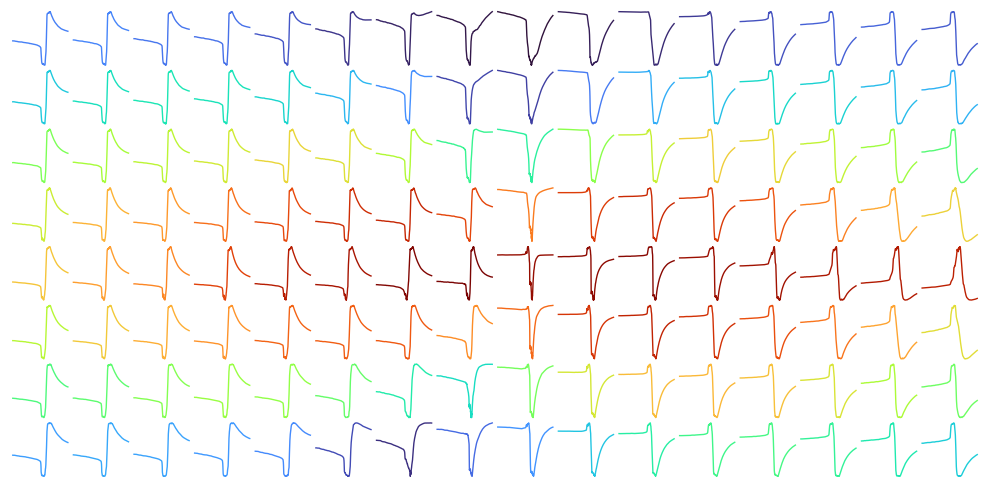

In [44]:
# plot spike location dependence
contact_ids = np.arange(0, 128, 1)

# get peak to peak amplitude (ppa)
min_s = all_spikes.min(axis=0)
max_s = all_spikes.max(axis=0)
peak_to_peak_amp = max_s - min_s

# map ppa to spike templates
import pandas as pd

colors = plt.cm.turbo(np.linspace(0, 1, 128))
df = pd.DataFrame(
    {"ppa": peak_to_peak_amp, "contact": np.arange(0, 128, 1)}
).sort_values(by="ppa", ascending=True)

df["colors"] = colors.tolist()
df = df.sort_values(by="contact")

# format contact grid
contact_grid = contact_ids.reshape(8, 16)

# Plot
fig, axes = plt.subplots(contact_grid.shape[0], contact_grid.shape[1], figsize=(10, 5))

# plot each contact's average spike panel in the x-y plane
c_i = 0
for ix in range(contact_grid.shape[0]):
    for jx in range(contact_grid.shape[1]):
        axes[ix, jx].plot(
            all_spikes[:, contact_grid[ix, jx]],
            color=df["colors"].iloc[c_i],
            linewidth=1,
        )
        axes[ix, jx].axis("off")
        # axes[ix,jx].set_title(contact_grid[ix,jx], fontsize=8)
        c_i += 1

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)

<>:10: DeprecationWarning: invalid escape sequence \m
<>:10: DeprecationWarning: invalid escape sequence \m
/tmp/ipykernel_287631/3836051311.py:10: DeprecationWarning: invalid escape sequence \m
  cax=ax, orientation='vertical', label='$\mu V$');


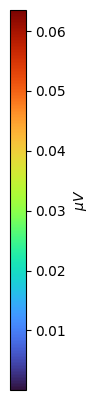

In [29]:
# get colorbar
import matplotlib

fig, ax = plt.subplots(figsize=(0.2, 10))
fig.subplots_adjust(bottom=0.5)
cmap = matplotlib.cm.turbo
norm = matplotlib.colors.Normalize(
    vmin=peak_to_peak_amp.min(), vmax=peak_to_peak_amp.max()
)
fig.colorbar(
    matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),
    cax=ax,
    orientation="vertical",
    label="$\mu V$",
)

TODO:
- possibly define metadata from the setup cell

In [6]:
# # save figure
# fig.savefig(FIG_PATH+".png")

# # write metadata
# metadata = {
#     "fig_path": FIG_PATH,
#     "creation_date": datetime.now().strftime("%d/%m/%Y %H:%M:%S"),
#     "simulation_date": SIMULATION_DATE,
#     "data_conf": data_conf,
#     "param_conf": param_conf,
#     "lfp_sampling_freq": LFP_SAMPLING_FREQ,
#     "spike_sampling_freq": SPIKE_SAMPLING_FREQ,
#     "channel_id": CHANNEL_ID,
#     "cell_gid": CELL_GID
#     }
# write_metadata(metadata, FIG_PATH)

Done